## Step one: load map image

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from yaml import load, dump
import skimage
import os

MAPS_DIR = 'maps'

map_name = 'asdf'
with open(os.path.join(MAPS_DIR, map_name+'.yaml'), 'r') as f:
    map_meta = load(f)

print(map_meta)
map_img = mpimg.imread(os.path.join(MAPS_DIR, map_meta['image']))
print(map_img.shape)

if map_meta['negate']:
    p = map_img / 255.0
else:
    p = (255 - map_img) / 255.0

plt.imshow(p, cmap='gray')
plt.show()

{'origin': [-40.969997, -20.49, 0.0], 'free_thresh': 0.196, 'occupied_thresh': 0.65, 'negate': 0, 'image': 'asdf.pgm', 'resolution': 0.02}
(4096, 4096)


<Figure size 640x480 with 1 Axes>

## Step two: identify occupied and free cells

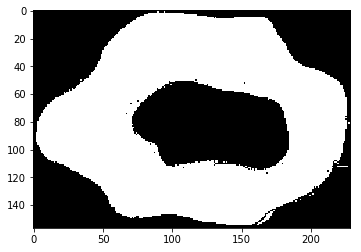

In [2]:
import numpy as np

occupied = np.zeros_like(map_img)
free     = np.zeros_like(map_img)

occupied[p > map_meta['occupied_thresh']] = 1.0
free[p < map_meta['free_thresh']] = 1.0

B = np.argwhere(occupied | free)
(ystart, xstart), (ystop, xstop) = B.min(0), B.max(0) + 1

free_trim = free[ystart:ystop, xstart:xstop]

plt.imshow(free_trim, cmap='gray')
plt.show()

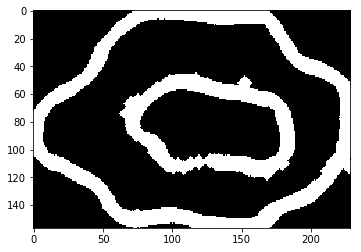

In [3]:
from skimage.morphology import binary_dilation

occupied_trim = occupied[ystart:ystop, xstart:xstop]

for x in range(5):
    occupied_trim = binary_dilation(occupied_trim)

free_trim = free_trim & (~occupied_trim)

plt.imshow(occupied_trim, cmap='gray')
plt.show()

## Step three: identify center line

/usr/local/lib/python2.7/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


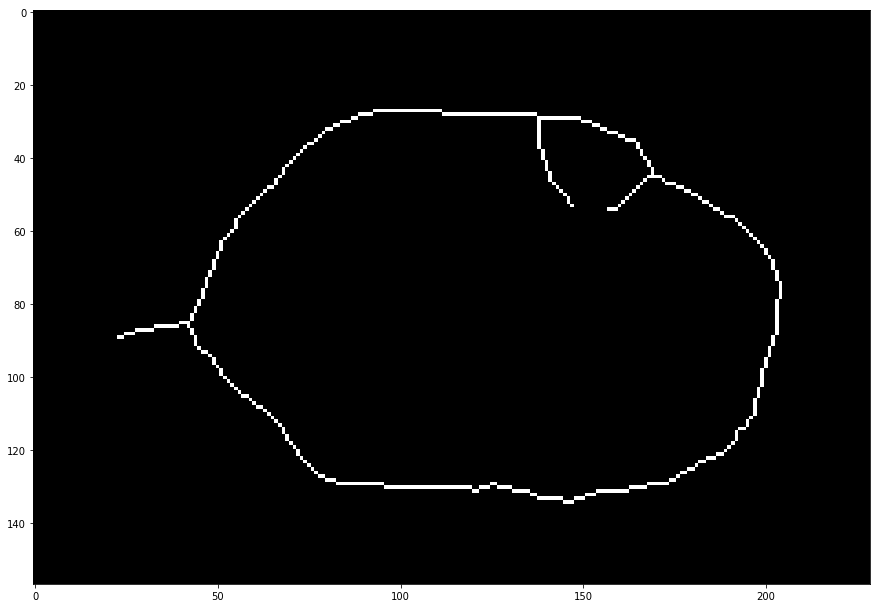

In [4]:
from skimage.morphology import binary_erosion, skeletonize, thin
from skimage.transform import resize

img_resized = resize(map_img, (map_img.shape[0] / 2, map_img.shape[1] / 2),
                       anti_aliasing=False)
skeleton = skeletonize(free_trim)

plt.figure(figsize=(15, 15))
plt.imshow(skeleton, cmap='gray')
plt.show()

## Step four: extract pixels belonging to the closed circuit

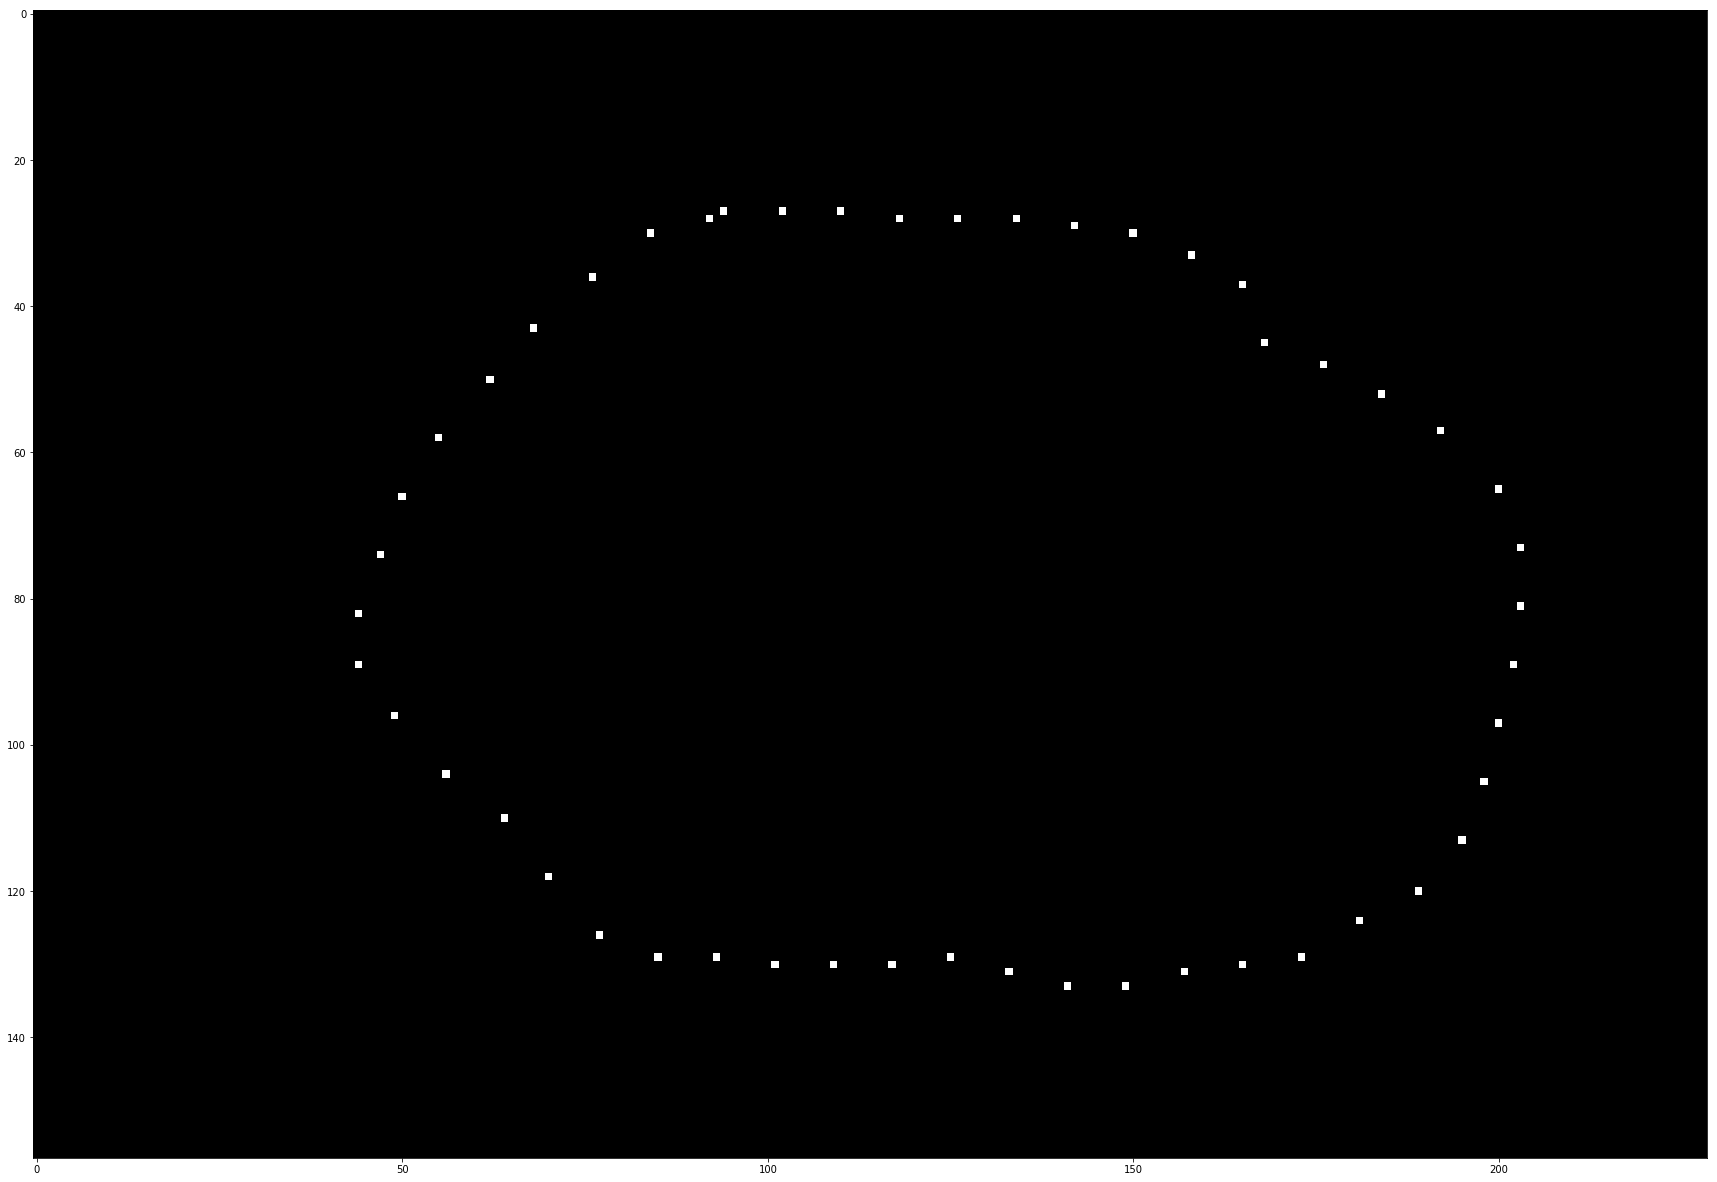

50


In [5]:
from itertools import permutations
import sys
sys.setrecursionlimit(999999999)

OFFSETS = [-1, 0, 1]
NEIGHBORHOOD = [(dy, dx) for dx in OFFSETS for dy in OFFSETS]

available = np.copy(skeleton).astype(np.bool)

def dfs(point, target, available, path, remaining_steps=15):
    x = point[0]
    y = point[1]
    
    if (remaining_steps == 0) and (point == target).all(): return True
    
    # Lower & upper bounds
    if x < 0 or x >= available.shape[1]: return False
    if y < 0 or y >= available.shape[0]: return False
    
    if not available[y, x]: return False
    
    remaining_steps = max(0, remaining_steps-1)
    
    available[y, x] = False
    path.append(point)
    
    for dx, dy in NEIGHBORHOOD:
        child_x = x + dx
        child_y = y + dy
        
        if dfs((child_x, child_y), target, available, path, remaining_steps):
            return True

    path.pop()
    return False

starting_points = np.transpose(np.nonzero(available))
for starting_point in starting_points:
    path = []
    
    if dfs(starting_point[::-1], starting_point[::-1], available, path):
        break

path = path[::-8]        
    
path_img = np.zeros_like(skeleton)
for point in path:
    path_img[point[1], point[0]] = 1

plt.figure(figsize=(30, 30))
plt.imshow(path_img, cmap='gray')
plt.show()

print(len(path))

## Step six: Save results to file

In [6]:
import pickle

data = {}

res = map_meta['resolution']

data['resolution'] = res
data['origin'] = [
    map_meta['origin'][0] + xstart * res,
    map_meta['origin'][1] + (map_img.shape[0] - ystop - 1) * res
]
data['pathpoints'] = [
    (data['origin'][0] + x*res, data['origin'][1] + (path_img.shape[0] - y - 1)*res)
    for x, y in path
]

with open(map_name+'.pkl', 'wb') as f:
    pickle.dump(data, f, 2)